In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from transformers import pipeline

In [4]:
df_movies = pd.read_csv('/content/drive/My Drive/ColabNotebooks/rotten_tomatoes_movies.csv')
df_critic_review = pd.read_csv('/content/drive/My Drive/ColabNotebooks/rotten_tomatoes_critic_reviews.csv')

In [5]:
df_movies_merged = df_critic_review.merge(df_movies, how='inner', on=['rotten_tomatoes_link'])
df_movies_merged = df_movies_merged[['rotten_tomatoes_link', 'movie_title', 'directors', 'review_content', 'review_type', 'tomatometer_status']]
df_movies_merged.head()

,rotten_tomatoes_link,movie_title,directors,review_content,review_type,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,"Uma Thurman as Medusa, the gorgon with a coiff...",Fresh,Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,With a top-notch cast and dazzling special eff...,Fresh,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,Whether audiences will get behind The Lightnin...,Fresh,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,What's really lacking in The Lightning Thief i...,Rotten,Rotten


In [6]:
df_movies_merged.isnull().sum()

rotten_tomatoes_link        0
movie_title                 0
directors               14464
review_content          65778
review_type                 0
tomatometer_status       1466
dtype: int64

In [7]:
df_movies_merged = df_movies_merged.dropna(subset=['review_content'])
df_movies_merged = df_movies_merged.dropna(subset=['tomatometer_status'])
df_movies_merged = df_movies_merged.dropna(subset=['directors'])
df_movies_merged.isnull().sum()

rotten_tomatoes_link    0
movie_title             0
directors               0
review_content          0
review_type             0
tomatometer_status      0
dtype: int64

In [8]:
df_sub = df_movies_merged[0:10000]
review_type = pd.DataFrame(df_sub['review_type'].replace(['Rotten', 'Fresh'],[0,1]))
df_ft_critics = pd.concat([df_sub[['review_content']],review_type], axis=1).dropna()
df_ft_critics.head()

,review_content,review_type
0,A fantasy adventure that fuses Greek mythology...,1
1,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,With a top-notch cast and dazzling special eff...,1
3,Whether audiences will get behind The Lightnin...,1
4,What's really lacking in The Lightning Thief i...,0


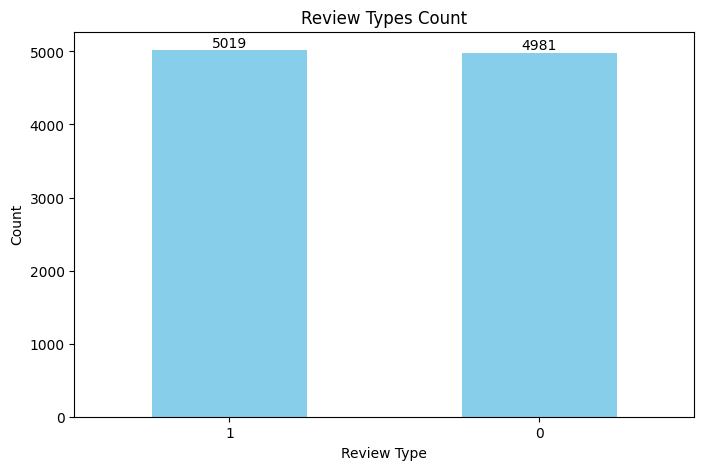

In [9]:
ax = df_ft_critics['review_type'].value_counts().plot(kind='bar', figsize=(8,5), color='skyblue')
ax.bar_label(ax.containers[0], label_type='edge', fontsize=10, rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.title('Review Types Count')
plt.show()

In [10]:
X = df_ft_critics['review_content']
y = df_ft_critics['review_type']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that aut

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [14]:
#example
df_ft_critics.review_content[10]

"This action-packed fantasy adventure, based on Rick Riordan's hit Percy Jackson and the Olympians series of books, is great fun, and deserves to find an audience with teens now bereft of any Harry Potter magic."

In [16]:
sent_pipeline(df_ft_critics.review_content[10])

[{'label': 'POSITIVE', 'score': 0.9998694658279419}]

In [32]:
#example
df_ft_critics.review_content[91]

"there's not one single thing in it that will appeal to a person who has ever seen a mythological origin story before, much less any other sort of adventure movie."

In [33]:
sent_pipeline(df_ft_critics.review_content[91])

[{'label': 'NEGATIVE', 'score': 0.9957250356674194}]

In [34]:
y_pred_sentiment = [sent_pipeline(review)[0]['label'] for review in X_test]
y_pred = np.where(np.array(y_pred_sentiment) == 'POSITIVE', 1, 0)

In [42]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.813
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1013
           1       0.80      0.83      0.82       987

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



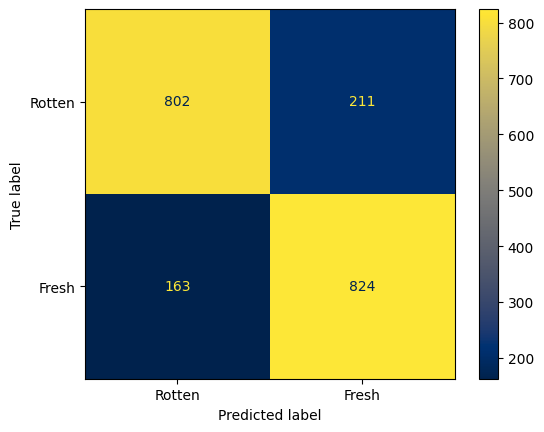

In [43]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Rotten', 'Fresh'])
disp.plot(cmap='cividis')
plt.show()

In [44]:
def predict_sentiment(movie_name, directors):
  df_movie = df_movies_merged[(df_movies_merged["movie_title"].str.contains(movie_name, case=False, na=False)) &
                                (df_movies_merged["directors"].str.contains(directors, case=False, na=False))]
  review_type = pd.DataFrame(df_movie['review_type'].replace(['Rotten', 'Fresh'],[0,1]))
  df_movie_rev = pd.concat([df_movie[['review_content']],review_type], axis=1).dropna()

  df_movie_rev['predicted_sentiment'] = df_movie_rev['review_content'].apply(lambda x: sent_pipeline(x)[0]['label'])
  df_movie_rev['predicted_label'] = df_movie_rev['predicted_sentiment'].replace({'NEGATIVE': 0, 'POSITIVE': 1})

  sentiment_counts = df_movie_rev['predicted_label'].value_counts()
  if sentiment_counts.get(1, 0) > sentiment_counts.get(0, 0):
        final_sentiment = 'Fresh'
  else:
        final_sentiment = 'Rotten'

  print(f"The movie '{movie_name}' is predicted to be: {final_sentiment}")

In [45]:
predict_sentiment("2001: A Space Odyssey", "Stanley Kubrick")

The movie '2001: A Space Odyssey' is predicted to be: Fresh


In [46]:
predict_sentiment("Goodfellas", "Martin Scorsese")

The movie 'Goodfellas' is predicted to be: Fresh


In [47]:
predict_sentiment("American Psycho", "Mary Harron")

The movie 'American Psycho' is predicted to be: Fresh


In [48]:
predict_sentiment("Pacific Rim Uprising", "Steven S. DeKnight")

The movie 'Pacific Rim Uprising' is predicted to be: Rotten
